In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models, layers



2024-08-10 14:56:02.501229: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 14:56:02.522290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 14:56:02.522313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 14:56:02.522979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 14:56:02.526690: I tensorflow/core/platform/cpu_feature_guar

In [3]:
print(tf.__version__)

2.15.0


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/dell/Desktop/chest_xray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 3 classes.


2024-08-10 14:56:04.614039: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-08-10 14:56:04.614057: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dell-Precision-3660
2024-08-10 14:56:04.614061: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dell-Precision-3660
2024-08-10 14:56:04.614123: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-08-10 14:56:04.614133: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-08-10 14:56:04.614136: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


In [6]:
class_names = dataset.class_names
class_names

['bact_pneumo', 'normal', 'viral_pneumo']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 0 0 2 2 2 2 0 1 2 0 0 1 1 1 0 0 1 2 0 2 0 0 1 0 0 1 0 0]


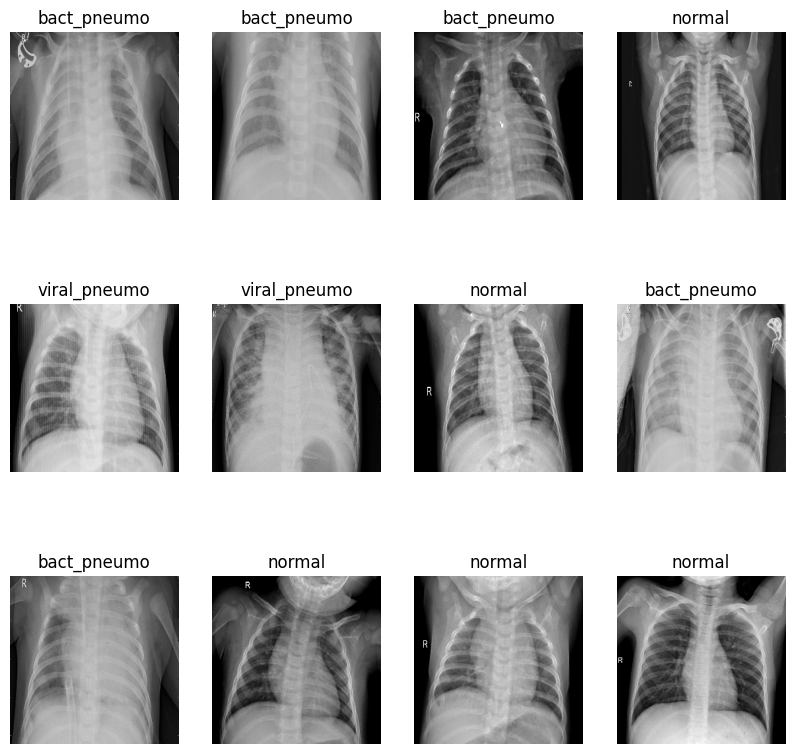

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)
len(val_ds)
len(test_ds)

19

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
146/146 [==============================] - 33s 203ms/step - loss: 1.0652 - accuracy: 0.4715 - val_loss: 1.0374 - val_accuracy: 0.5000
Epoch 2/50
146/146 [==============================] - 30s 208ms/step - loss: 0.9663 - accuracy: 0.5505 - val_loss: 0.9831 - val_accuracy: 0.5608
Epoch 3/50
146/146 [==============================] - 32s 222ms/step - loss: 0.8424 - accuracy: 0.6286 - val_loss: 0.7600 - val_accuracy: 0.6545
Epoch 4/50
146/146 [==============================] - 32s 218ms/step - loss: 0.7513 - accuracy: 0.6768 - val_loss: 0.7928 - val_accuracy: 0.6615
Epoch 5/50
146/146 [==============================] - 32s 218ms/step - loss: 0.6964 - accuracy: 0.7078 - val_loss: 0.7156 - val_accuracy: 0.6927
Epoch 6/50
146/146 [==============================] - 32s 220ms/step - loss: 0.6449 - accuracy: 0.7215 - val_loss: 0.7212 - val_accuracy: 0.6719
Epoch 7/50
146/146 [==============================] - 32s 220ms/step - loss: 0.6264 - accuracy: 0.7404 - val_loss: 0.6278 - val_ac

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

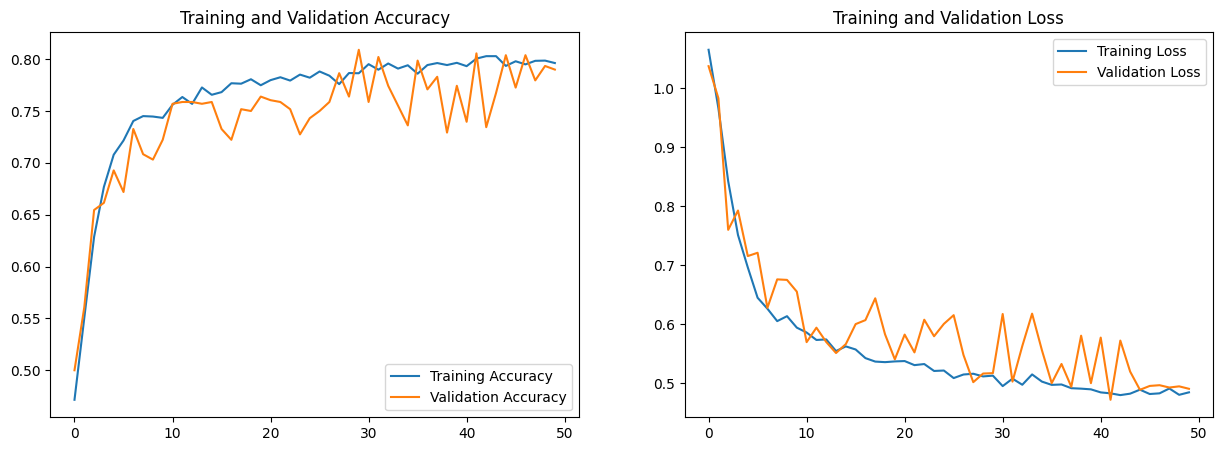

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 85ms/step


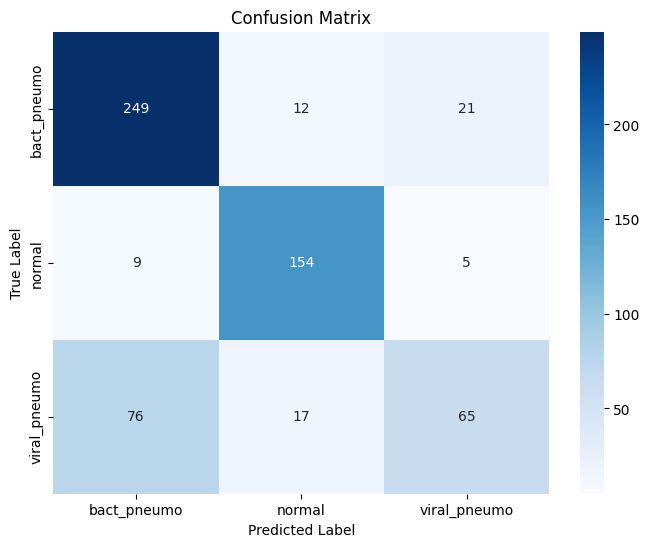

In [25]:
# Get the true labels and the predicted labels
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

 bact_pneumo       0.75      0.88      0.81       282
      normal       0.84      0.92      0.88       168
viral_pneumo       0.71      0.41      0.52       158

    accuracy                           0.77       608
   macro avg       0.77      0.74      0.74       608
weighted avg       0.76      0.77      0.75       608



In [29]:
import cv2

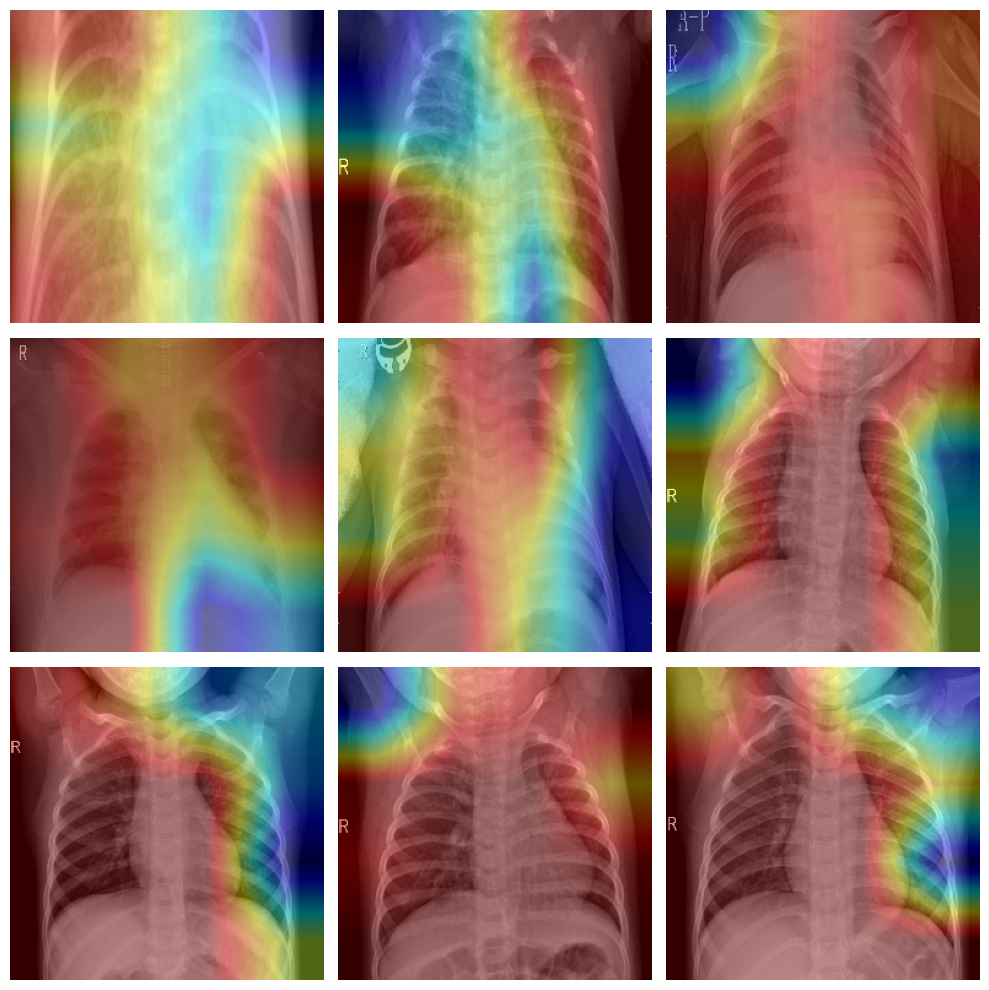

In [34]:

# CAM Implementation
last_conv_layer_name = 'conv2d_5'  # Change to the name of the last conv layer
grad_model = models.Model(inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

# Function to create CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display CAM overlay on the image
def display_gradcam(img_array, heatmap, alpha=0.4):
    img = np.array(img_array[0])
    
    img = np.uint8(255 * img / np.max(img))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Select a batch of images from the dataset
for images, labels in dataset.take(1):
    imgs_array = images[:9]  # Select first 9 images for a 3x3 grid

# Name of the last convolutional layer
last_conv_layer_name = 'conv2d_5'  # Adjust this based on your model's layer names

# Generate the CAM images
cam_images = []
for img in imgs_array:
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_image = display_gradcam(img_array, heatmap)
    cam_images.append(cam_image)

# Display the 3x3 grid of CAM images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(cam_images[i])
    ax.axis('off')
plt.tight_layout()
plt.show()